In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib
from skimage import segmentation

In [2]:
RANDOM_STATE = 42
# RANDOM_STATE = None

MODEL_OUTPUT_DIR = Path(
    "/mnt/towbin.data/shared/bgusev/stardist_egg_seg/xgboost_training/egg_classifier_models"
)
MODEL_OUTPUT_NAME = "egg_classifier_v1.joblib.pkl"  # will not overwrite, will raise an error if file exists

TRAINING_DATA_SET = Path(
    "/mnt/towbin.data/shared/bgusev/stardist_egg_seg/xgboost_training/training_data/seg_features.csv"
)

PROPERTIES = joblib.load("egg_classifier_models/props.joblib.pkl")

# equalise class counts by dropping 'excess' data
# this is a simple way to deal with class imbalance
EQUALISE_CLASSES = True

In [3]:
training_df = pd.read_csv(TRAINING_DATA_SET)
print(training_df.shape)
training_df.head()

(93911, 136)


,area,area_bbox,area_convex,axis_major_length,axis_minor_length,bbox-0,bbox-1,bbox-2,bbox-3,centroid_local-0,...,moments_weighted_normalized-3-0,moments_weighted_normalized-3-1,moments_weighted_normalized-3-2,moments_weighted_normalized-3-3,perimeter,perimeter_crofton,solidity,class,Time,Point
0,498.0,667.0,521.0,28.438778,22.348920,1592,958,1621,981,13.387550,...,0.002327,-0.000483,0.000055,-0.000021,84.426407,82.722770,0.955854,egg,1,15
1,3739.0,4920.0,3872.0,127.288747,38.265971,1457,1580,1497,1703,20.815191,...,-0.000055,0.000026,-0.000003,0.000002,291.681241,279.212674,0.965651,other,1,15
2,464.0,648.0,487.0,28.912659,20.528012,1297,1583,1321,1610,11.148707,...,-0.000601,-0.001563,0.000009,-0.000182,81.012193,79.485892,0.952772,egg,1,15
3,487.0,780.0,517.0,34.987935,17.822422,1462,495,1492,521,14.347023,...,-0.001896,0.006149,-0.000119,0.000645,90.083261,88.871202,0.941973,egg,1,15
4,199.0,270.0,212.0,17.326466,14.701623,980,1406,998,1421,8.115578,...,0.002410,-0.001219,-0.000024,-0.000107,52.041631,52.020077,0.938679,egg,1,15


In [4]:
print(list(training_df.columns))

['area', 'area_bbox', 'area_convex', 'axis_major_length', 'axis_minor_length', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid_local-0', 'centroid_local-1', 'centroid_weighted_local-0', 'centroid_weighted_local-1', 'eccentricity', 'equivalent_diameter_area', 'extent', 'feret_diameter_max', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'label', 'moments-0-0', 'moments-0-1', 'moments-0-2', 'moments-0-3', 'moments-1-0', 'moments-1-1', 'moments-1-2', 'moments-1-3', 'moments-2-0', 'moments-2-1', 'moments-2-2', 'moments-2-3', 'moments-3-0', 'moments-3-1', 'moments-3-2', 'moments-3-3', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'moments_hu-0', 'moments_hu-1', 'm

In [5]:
def class_size_equalise(dataframe, random_state=None):
    min_class_size = dataframe["class"].value_counts().min()
    equalised_df = dataframe.groupby("class").sample(
        min_class_size, replace=False, random_state=random_state
    )
    the_rest = dataframe.drop(equalised_df.index)
    return equalised_df, the_rest

In [6]:
original_class_distribution = pd.DataFrame(training_df["class"].value_counts())
print(f"Original class distribution:\n{original_class_distribution}")
print()

if EQUALISE_CLASSES:
    training_df_sample, training_df_dropped = class_size_equalise(
        training_df, RANDOM_STATE
    )
    new_class_distribution = pd.DataFrame(training_df_sample["class"].value_counts())
    dropped_class_distribution = pd.DataFrame(
        training_df_dropped["class"].value_counts()
    )
    print(f"Dropped {len(training_df_dropped)} rows")
    print(f"Dropped class distribution:\n{dropped_class_distribution}")
    print()
    print(f"New class distribution:\n{new_class_distribution}")
else:
    training_df_sample = training_df
    training_df_dropped = None

    print("Nothing dropped, df kept as is")

Original class distribution:
       count
class       
egg    88887
other   5024

Dropped 83863 rows
Dropped class distribution:
       count
class       
egg    83863

New class distribution:
       count
class       
egg     5024
other   5024


In [7]:
cols_to_drop = set(
    [
        "label",
        "Time",
        "Point",
        "male",
        "is_in_worm",
        "is_egg",
        "class",
    ]
)

# ignore to not raise error if a col_to_drop does not exist
feature_df = training_df_sample.drop(columns=list(cols_to_drop), errors="ignore")
features = feature_df.values
print(f"Features kept: {list(feature_df.columns)}")
print(f"Feature array shape (i.e. 'X's): {features.shape}")

targets = training_df_sample["class"].values
print(f"Target array shape (i.e. 'y's): {targets.shape}")
classes, counts = np.unique(targets, return_counts=True)
class_count_dict = dict(zip(classes, counts))
print(f"class:count {class_count_dict}")

Features kept: ['area', 'area_bbox', 'area_convex', 'axis_major_length', 'axis_minor_length', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid_local-0', 'centroid_local-1', 'centroid_weighted_local-0', 'centroid_weighted_local-1', 'eccentricity', 'equivalent_diameter_area', 'extent', 'feret_diameter_max', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'moments-0-0', 'moments-0-1', 'moments-0-2', 'moments-0-3', 'moments-1-0', 'moments-1-1', 'moments-1-2', 'moments-1-3', 'moments-2-0', 'moments-2-1', 'moments-2-2', 'moments-2-3', 'moments-3-0', 'moments-3-1', 'moments-3-2', 'moments-3-3', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'moments_hu-0', 'moments_hu-

In [8]:
X_train, X_test, y_train_true, y_test_true = train_test_split(
    features,
    targets,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=targets,
)

In [9]:
y_train_classes, y_train_counts = np.unique(y_train_true, return_counts=True)
y_train_classes = dict(zip(y_train_classes, y_train_counts))
y_test_classes, y_test_counts = np.unique(y_test_true, return_counts=True)
y_train_classes = dict(zip(y_test_classes, y_test_counts))

print(f"Train class distribution:\n{y_train_classes}")
print(f"Test class distribution:\n{y_test_classes}")

Train class distribution:
{'egg': 1005, 'other': 1005}
Test class distribution:
['egg' 'other']


In [10]:
n_classes = len(np.unique(targets))
if n_classes == 1:
    raise ValueError("Only one class present in the data, cannot train a classifier")
elif n_classes == 2:
    objective = "binary:logistic"  # default for binary classification
else:  # n_classes > 2
    objective = "multi:softmax"  # multiclass classification
print(f"Objective: {objective}")
model = XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,  # explicit false recommended online due to deprecation warning
    learning_rate=0.1,
    objective=objective,
)

label_encoder = LabelEncoder()
label_encoder.fit(targets)
print(f"Classes: {label_encoder.classes_}")

Objective: binary:logistic
Classes: ['egg' 'other']


In [16]:
targets

array(['egg', 'egg', 'egg', ..., 'other', 'other', 'other'], dtype=object)

In [19]:
label_encoder.transform(targets)

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
model.fit(X_train, label_encoder.transform(y_train_true))

y_test_pred = label_encoder.inverse_transform(model.predict(X_test))

accuracy = balanced_accuracy_score(y_test_true, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test_true, y_test_pred))

Accuracy: 96.27%
              precision    recall  f1-score   support

         egg       0.95      0.98      0.96      1005
       other       0.98      0.95      0.96      1005

    accuracy                           0.96      2010
   macro avg       0.96      0.96      0.96      2010
weighted avg       0.96      0.96      0.96      2010



In [12]:
if training_df_dropped is not None:
    # check accuracy on the dropped data
    # this will create warnings since the dropped_df will not contain the rarest class
    y_dropped_true = training_df_dropped["class"].values
    y_dropped_pred = label_encoder.inverse_transform(
        model.predict(training_df_dropped[feature_df.columns].values)
    )
    accuracy = balanced_accuracy_score(
        y_dropped_true,
        y_dropped_pred,
    )
    print("Accuracy on dropped data: %.2f%%" % (accuracy * 100.0))
    print(classification_report(y_dropped_true, y_dropped_pred))

/home/bgusev/micromamba/envs/stardist_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy on dropped data: 97.95%


/home/bgusev/micromamba/envs/stardist_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bgusev/micromamba/envs/stardist_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         egg       1.00      0.98      0.99     83863
       other       0.00      0.00      0.00         0

    accuracy                           0.98     83863
   macro avg       0.50      0.49      0.49     83863
weighted avg       1.00      0.98      0.99     83863



/home/bgusev/micromamba/envs/stardist_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
model_file_path = MODEL_OUTPUT_DIR / MODEL_OUTPUT_NAME
model_dict = {
    "model": model,
    "property_features": PROPERTIES,
    "label_encoder": label_encoder,
}
print(f"Saved properties: {PROPERTIES}")
if not model_file_path.exists():
    joblib.dump(model_dict, model_file_path)
    # model.save_model(model_file_path)
    print(f"Model saved to {model_file_path}")
else:
    raise FileExistsError(f"Model file {model_file_path} already exists")

Saved properties: ('area', 'area_bbox', 'area_convex', 'axis_major_length', 'axis_minor_length', 'bbox', 'centroid_local', 'centroid_weighted_local', 'eccentricity', 'equivalent_diameter_area', 'extent', 'feret_diameter_max', 'inertia_tensor_eigvals', 'label', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'moments_weighted', 'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized', 'perimeter', 'perimeter_crofton', 'solidity')
Model saved to /mnt/towbin.data/shared/bgusev/stardist_egg_seg/xgboost_training/egg_classifier_models/egg_classifier_v1.joblib.pkl


In [14]:
top_n_features = 15

feature_names = feature_df.columns
feature_importances = model.feature_importances_

sort_idxs = np.argsort(feature_importances)[::-1]
feature_importances_filt = feature_importances[sort_idxs][:top_n_features]
feature_names_filt = feature_names[sort_idxs][:top_n_features]

len(feature_names_filt), len(feature_importances_filt)

(15, 15)

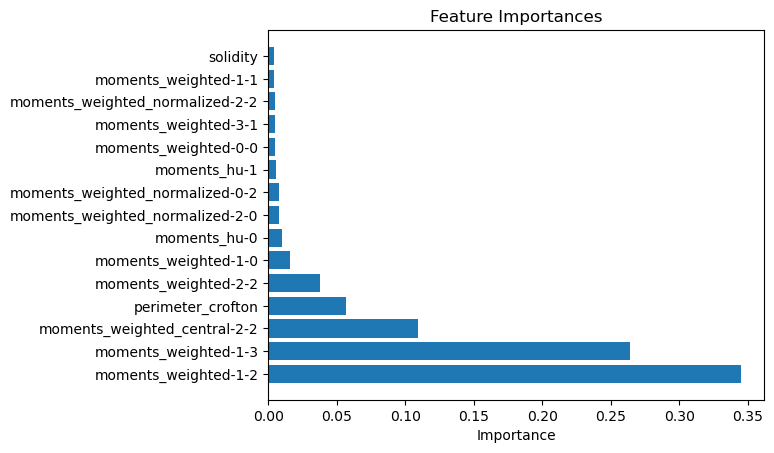

In [15]:
# Assuming feature_importances and feature_names are defined
# feature_importances = np.array([...])
# feature_names = np.array([...])

fig, ax = plt.subplots()

ax.barh(feature_names_filt, feature_importances_filt)
ax.set_yticks(feature_names_filt)
ax.set_yticklabels(feature_names_filt)
ax.set_xlabel("Importance")
ax.set_title("Feature Importances")

plt.show()

In [20]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tifffile
from csbdeep.utils import normalize
from joblib import Parallel, delayed
from skimage import measure, morphology, util
from stardist.models import StarDist2D, StarDist3D
from tqdm.notebook import tqdm

# stardist does not offer a 'list' of pretrained models. calling StarDist2D.from_pretrained() just prints available models to console
# so we define a list of models here to check against
DEFAULT_MODELS_2D = {
    "2D_versatile_fluo",
    "2D_versatile_he",
    "2D_paper_dsb2018",
}
# no pretrained 3D models are available in stardist at the moment. They have expressed the desire to add them in the future
# https://stardist.net/faq/#is-there-a-pretrained-model-for-3d-or-do-you-plan-to-release-one
DEFAULT_MODELS_3D = set()


def preprocess_image(image):
    # keep preprocessing minimal, stardist by-and-large is robust to _natural_ intensity variations,
    # and excessive preprocessing can lead to segmentation artifacts
    image, crop_mask = square_crop(image, return_mask=True)
    image = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(image)
    return image, crop_mask


def square_crop(image, crop_axes=(-2, -1), return_mask=False):
    if len(crop_axes) < 2:
        raise ValueError(
            "square_crop needs at least two axes to crop from. The smallest axis size determines the side length of the resultant image"
        )

    crop_axes = np.array(crop_axes)
    # convert negative axes to positive
    crop_axes = crop_axes % image.ndim

    crop_ax_sizes = [image.shape[ax] for ax in crop_axes]
    min_size = min(crop_ax_sizes)

    # by default, keep everything from each axis
    crop_slices = [np.s_[:]] * image.ndim
    for ax in crop_axes:
        size_delta = image.shape[ax] - min_size
        crop_amount = size_delta // 2
        i_min = crop_amount
        i_max = image.shape[ax] - (size_delta - crop_amount)
        # overwrite the default slice with the cropped slice
        crop_slices[ax] = np.s_[i_min:i_max]

    crop_slices = tuple(crop_slices)
    cropped_image = image[crop_slices]
    if return_mask:
        crop_mask = np.zeros_like(image, dtype=bool)
        crop_mask[crop_slices] = True
        return cropped_image, crop_mask
    else:
        return cropped_image


def parallel_load_files(files, channel, threads=1):
    # since this is io, threading is sufficient and has lower overhead
    # return as generator to avoid loading all files into memory at once - they will be loaded on demand,
    # hopefully as fast as stardist can handle. Nonetheless, can still be rate limitting if cluster is slow
    image_generator = Parallel(
        n_jobs=threads, backend="threading", return_as="generator"
    )(delayed(tifffile.imread)(file, key=channel) for file in files)
    return image_generator


def process_image(stardist_model, raw_image, scale=1):
    image, crop_mask = preprocess_image(raw_image)
    egg_seg = stardist_seg(model=stardist_model, image=image, scale=scale)

    uncropped_egg_seg = np.zeros_like(raw_image, dtype=egg_seg.dtype)
    uncropped_egg_seg[crop_mask] = egg_seg.flat
    # uncropped_egg_seg now same shape as raw_image
    return uncropped_egg_seg


def stardist_seg(model, image, scale):
    # strictly speaking a pre-processing step, but it's used in all stardist examples and was used for the model training,
    # so it's added here
    # it also converts to float32 by default
    image = normalize(image)
    seg, _ = model.predict_instances(image, scale=scale)
    return seg


def load_stardist_model(model_name):
    # stardist automatically loads the model onto gpu
    # if no gpu is present, cpus will be used
    if model_name in DEFAULT_MODELS_2D:
        model = StarDist2D.from_pretrained(model_name)
    elif model_name in DEFAULT_MODELS_3D:
        model = StarDist3D.from_pretrained(model_name)
    else:
        raise ValueError(
            f"Model {model_name} not found in default stardist models. Custom models not yet supported."
        )
    return model


def seg_analysis(properties, seg, image=None, spacing=(1, 1)):
    props_df = measure.regionprops_table(
        seg,
        intensity_image=image,
        properties=properties,
        spacing=spacing,
    )
    props_df = pd.DataFrame(props_df)
    return props_df


def is_in_worm(region_mask, worm_seg):
    return np.any(worm_seg[region_mask] > 0)


def preprocess_worm_seg(seg):
    min_size = 500
    new_seg = np.zeros_like(seg)

    connected_components = measure.label(seg > 0)
    joint_seg = segmentation.join_segmentations(
        seg, connected_components, return_mapping=False
    )

    for region in measure.regionprops(joint_seg):
        if region.num_pixels <= min_size:
            continue
        ys, xs = region.coords.T
        mask = np.zeros_like(seg, dtype=bool)
        mask[ys, xs] = True
        mask = morphology.isotropic_erosion(mask, radius=5)

        new_seg[mask] = seg[mask]
    return new_seg


def semantic_seg(egg_seg, worm_seg):
    properties = ["label"]
    extra_properties = [is_in_worm]

    props_table = measure.regionprops_table(
        egg_seg, worm_seg, properties=properties, extra_properties=extra_properties
    )
    props_df = pd.DataFrame(props_table)
    props_df["class"] = props_df["is_in_worm"].apply(
        lambda x: "egg" if not x else "other"
    )
    props_df = props_df.drop(columns=["is_in_worm"])
    return props_df


def process_row(row):
    time = row["Time"]
    point = row["Point"]
    egg_seg_file = row["stardist_seg"]
    worm_seg_file = row["manual_seg"]
    raw_file = row["training_image"]

    egg_seg = tifffile.imread(egg_seg_file)
    worm_seg = tifffile.imread(worm_seg_file)
    worm_seg = preprocess_worm_seg(worm_seg)

    raw = tifffile.imread(raw_file)

    props_df = seg_analysis(
        egg_seg,
        raw,
        spacing=(1, 1),
    )

    semantic_df = semantic_seg(egg_seg, worm_seg)

    combined_df = props_df.merge(semantic_df, on="label", how="outer")
    combined_df["Time"] = time
    combined_df["Point"] = point
    return combined_df


stardist_model = load_stardist_model("2D_versatile_fluo")

2024-06-18 16:59:43.997139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 16:59:43.997194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 16:59:43.997202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 16:59:44.014439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [21]:
exp_filemap = pd.read_csv(
    "/mnt/towbin.data/shared/smarin/data/2024_02_07_lifespan_wBT318_20C/analysis/report/analysis_filemap.csv"
)[["Time", "Point", "raw"]]

In [28]:
exp_filemap.iloc[[0]]

,Time,Point,raw
0,0,0,/mnt/towbin.data/shared/smarin/data/2024_02_07...


Time: 10, Point: 0


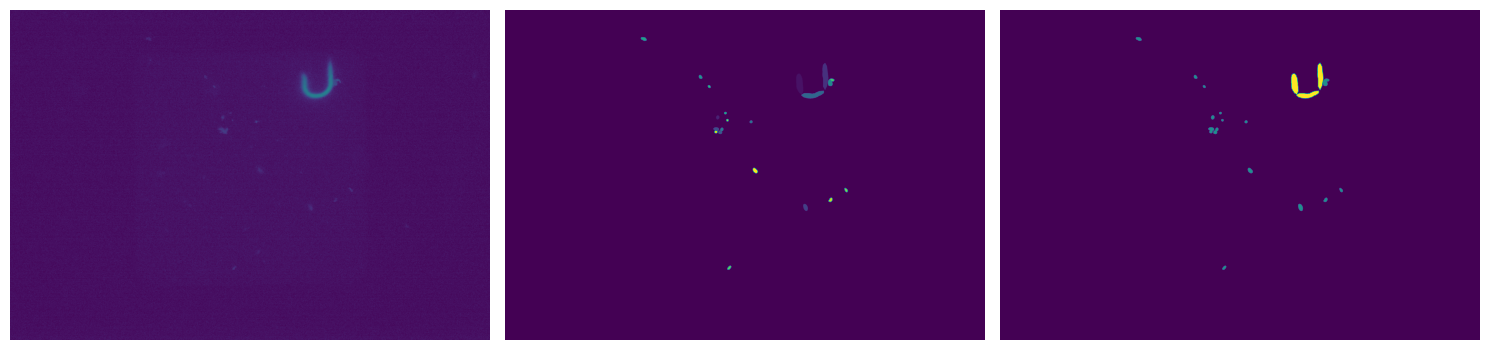

In [31]:
# random_row = exp_filemap.sample(1)
random_row = exp_filemap.iloc[[10]]

time = random_row["Time"].values[0]
point = random_row["Point"].values[0]
print(f"Time: {time}, Point: {point}")
raw = tifffile.imread(random_row["raw"].values[0], key=1)
sd_seg = process_image(stardist_model, raw, scale=0.5)

features = seg_analysis(PROPERTIES, sd_seg, raw, spacing=(1, 1))
semantic_labels = (
    model.predict(features.drop(columns=list(cols_to_drop), errors="ignore").values) + 1
)
instance_labels = features["label"].values

instance_seg = util.map_array(sd_seg, instance_labels, semantic_labels)
raw = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(raw)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
[ax.axis("off") for ax in axs]
[ax.imshow(img) for ax, img in zip(axs, [raw, sd_seg, instance_seg])]
fig.tight_layout()

In [27]:
# Exp 2 test

In [28]:
path = "/mnt/towbin.data/shared/plenart/lifespan_20240404-20240605/raw_tiff_combined_channels"
files = [f for f in Path(path).rglob("*.tiff")]
print(len(files))

184800


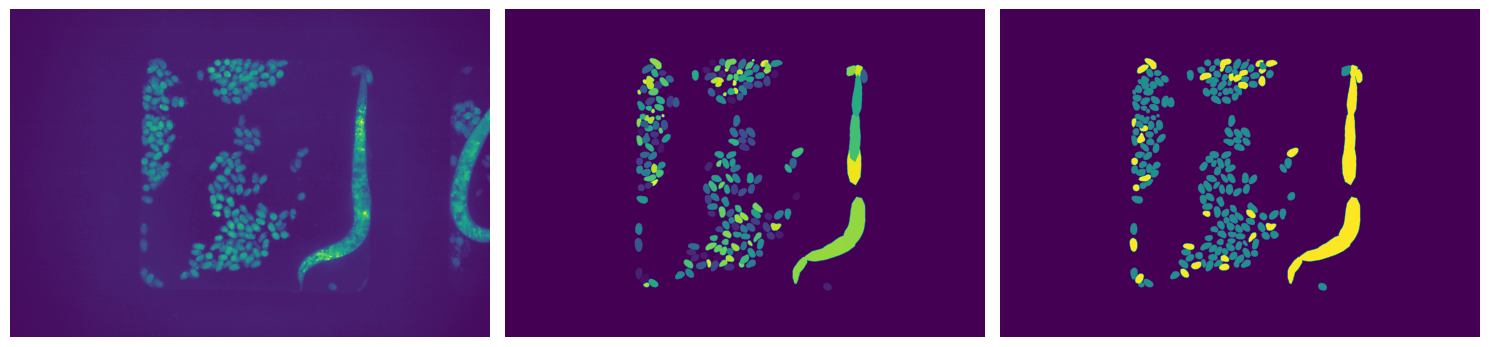

In [65]:
random_file = files[np.random.randint(0, len(files))]

raw = tifffile.imread(random_file, key=1)

sd_seg = process_image(stardist_model, raw, scale=0.5)

features = seg_analysis(sd_seg, raw, spacing=(1, 1))
semantic_labels = (
    model.predict(features.drop(columns=list(cols_to_drop), errors="ignore").values) + 1
)
instance_labels = features["label"].values

instance_seg = util.map_array(sd_seg, instance_labels, semantic_labels)
raw = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(raw)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
[ax.axis("off") for ax in axs]
[ax.imshow(img) for ax, img in zip(axs, [raw, sd_seg, instance_seg])]
fig.tight_layout()

In [66]:
type(model)

xgboost.sklearn.XGBClassifier